In [10]:
 pip install statsmodels 

Note: you may need to restart the kernel to use updated packages.


In [11]:
pip install xlwt

Note: you may need to restart the kernel to use updated packages.


In [12]:
 pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


In [13]:
pip install -U scikit-learn scipy matplotlib

Note: you may need to restart the kernel to use updated packages.


In [14]:
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
import numpy as np
import math
from pykalman import KalmanFilter
import statsmodels.api as sm
from matplotlib.ticker import FormatStrFormatter
import scipy.stats as stats
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.metrics import r2_score
import glob 
import os 
import statsmodels.formula.api as smf


In [15]:
#Define the following paths/parameters

#Enter currect path of python file. 
#Folder should only be filled  with  original station excels
current_directory='my_path'
current_directory='F:/Diplomatiki/final_script_for_submission'

#Enter path of folder for CH4 data, where MergedCH4.xlsx file is stored
CH4_folder='my_path/CH4'
CH4_folder='F:/Diplomatiki/final_script_for_submission/CH4'

#Enter path  of folder in which imputed data will be stored separately
my_imputed_folder='my_path/imputed'
my_imputed_folder='F:/Diplomatiki/final_script_for_submission/imputed'

#Define first day of year of interest
start_year='2023-01-01'

In [16]:
#Impute CH4 data separately

Merged_CH4_path= CH4_folder+'/MergedCH4.xlsx'
df_original = pd.read_excel(Merged_CH4_path,usecols=['CH4 (ppb)']) 

#Fill empty cells of CH4 file with mean value of CH4 data
temp=df_original.dropna()
a=temp.mean(skipna=True)
df=df_original.fillna(a)
array = df.to_numpy()

#Print mean value
print(a)

CH4 (ppb)    1899.567205
dtype: float64


In [17]:
#Kalman imputation of CH4 values

# Define Kalman filter parameters
transition_matrices = [1]  
observation_matrices = [1]  
initial_state_mean = a  #Initial guess for the mean value, equal with CH4 mean value
initial_state_covariance =1  
observation_covariance = 1 
transition_covariance = 0.01  

# Create Kalman filter
kf = KalmanFilter(
    transition_matrices=transition_matrices,
    observation_matrices=observation_matrices,
    initial_state_mean=initial_state_mean,
    initial_state_covariance=initial_state_covariance,
    observation_covariance=observation_covariance,
    transition_covariance=transition_covariance
)


#Apply Kalman smoother
state_means = kf.smooth(array.reshape(-1, 1))[0].flatten()
state_means=pd.DataFrame(state_means)

#Add column name, same as column name from the original CH4 data
state_means.columns=["CH4 (ppb)"]


#Replace NaN values in the original data set with Kalman imputed values
for i in range (df.shape[0]):
    if math.isnan(df_original['CH4 (ppb)'][i]):
        df_original['CH4 (ppb)'][i]=state_means['CH4 (ppb)'][i]

dates = pd.read_excel(Merged_CH4_path,usecols=['datetime'])
CH4=pd.concat([dates,df_original],axis=1)
CH4.columns=["datetime","CH4 imputed"]

#Make a new CH4 column with the imputed data in the merged excel
originalexcel=pd.read_excel(Merged_CH4_path)
df_imputed=pd.concat([originalexcel,CH4['CH4 imputed']],axis=1)

#Remove "unamed columns" due to concat function
df_imputed.drop(df_imputed.columns[df_imputed.columns.str.contains('Unnamed',case = False)],axis = 1, inplace = True)

Merged_CH4_path_imputed=CH4_folder+'/MergedCH4_imputed.xlsx'
df_imputed.to_excel(Merged_CH4_path_imputed)  
print(df_imputed)

      datetime                                   ID    CH4 (ppb)  CH4 imputed  \
0   2023-01-01                       Komotini,Thiva  1907.760876  1907.760876   
1   2023-01-02                 Komotini,South,Thiva  1900.907657  1900.907657   
2   2023-01-03                                  NaN          NaN  1901.210263   
3   2023-01-04            Komotini,Ptolemaida,Thiva  1896.959025  1896.959025   
4   2023-01-05                           Ptolemaida  1906.878909  1906.878909   
..         ...                                  ...          ...          ...   
360 2023-12-27        Megalopoli,Thessaloniki,Thiva  1897.127279  1897.127279   
361 2023-12-28  Corinth,Komotini,South,Thessaloniki  1880.951731  1880.951731   
362 2023-12-29                             Komotini  1919.117143  1919.117143   
363 2023-12-30                                  NaN          NaN  1904.481686   
364 2023-12-31                                  NaN          NaN  1904.433027   

     CH4 imputed  
0    190

In [18]:
#Create a function to calculate Kalman values for the rest of the gases, for ONE station excel
#Arguments: path: current directory where original station data are stored
#           stations_imputed: path for imputed data
#           Merged_CH4_path_imputed: path of CH4 folder

def Kalman(path,stations_imputed,Merged_CH4_path_imputed):
    list_df=[]
    station_excel=pd.read_excel(path)

    #Make a list where each element is a dataframe of a gas. Remember, element [0] is datetime
    for columns in station_excel.columns:
        gas = pd.read_excel(path,usecols=[columns])
        list_df.append(gas)
    
    #Drop first column with indexes and store datetime in "datetimes". Drop CH4 column too
    del list_df[0] #delete index
    datetimes=list_df[0] #Store datetime in a new dataframe
    del list_df[1] #delete CH4 column
    del list_df[0] #delete datetime column

    
    #Before applying Kalman filter,for each gas fill empty rows with mean of non empty values 

    #Add missing entries of year of interest
    dates = pd.date_range(start=start_year, periods=365)
    dates=pd.DataFrame(dates)
    dates.columns=['datetime']
    excel=pd.DataFrame(dates)
  
   
    #for each column (each gas)
    for gas in list_df:

    
        new=pd.concat([datetimes, gas], ignore_index=False,axis=1)
        originalelement=pd.merge(new,dates, on='datetime',how='right').drop(columns='datetime')


        #Fill empty rows with mean of non empty values
        temp=originalelement.dropna()
        mean=temp.mean(skipna=True)
        element=originalelement.fillna(mean)
        element=element.to_numpy()
         
        # Define the Kalman filter parameters
        transition_matrices = [1]  
        observation_matrices = [1] 
        initial_state_mean = mean  
        initial_state_covariance =1  
        observation_covariance = 1 
        transition_covariance = 0.01  

        # Create Kalman filter
        kf = KalmanFilter(
            transition_matrices=transition_matrices,
            observation_matrices=observation_matrices,
            initial_state_mean=initial_state_mean,
            initial_state_covariance=initial_state_covariance,
            observation_covariance=observation_covariance,
            transition_covariance=transition_covariance
            )   
        
        #Apply Kalman smooth filter
        state_means = kf.smooth(element.reshape(-1, 1))[0].flatten()
        state_means=pd.DataFrame(state_means)
        element=pd.DataFrame(element)
        gasname=gas.columns[0]
       

        #define column names
        state_means.columns=[gasname]
        element.columns=[gasname]

        
        #replace NaN values in the original data set with Kalman imputed values
        for i in range (element.shape[0]):
            if math.isnan(originalelement[gasname][i]):
                originalelement[gasname][i]=state_means[gasname][i] 

        
        excel=pd.concat([excel,originalelement],axis=1)

    #Add CH4 imputed column
    CH4 = pd.read_excel(Merged_CH4_path_imputed,usecols=['CH4 imputed'])   #same in previous cell

    #split excel (which includes dates,and gases apart from CH4) in half, in order to get CH4 column, right after datetime column
    firsthalf_excel=excel.iloc[:,0]
    secondhalf_exel=excel.iloc[:,1:]
    excel=pd.concat([firsthalf_excel,CH4,secondhalf_exel],axis=1)
    name_excel=path.split('/')[-1] 
    name_excel=name_excel.split('.')[0]+'_imputed'+'.'+name_excel.split('.')[1]
    
    #Store imputed files in different path
    excel.to_excel(stations_imputed+'/'+name_excel) 

    return excel


#Apply Kalman function to all station excels

# Use glob to get all the csv station files stored in the same path with current python file.
# No other csv files should be stored there.


os.chdir(current_directory)
path = os.getcwd() 
csv_files = glob.glob(os.path.join(path, "*.xlsx")) 

# Replace "\\" with "/" for every excel path
csv_files = [file.replace("\\", "/") for file in csv_files]

imputed_excels=[Kalman(csv_file,my_imputed_folder,Merged_CH4_path_imputed) for csv_file in csv_files]


In [20]:
#Function that checks if all timeseries of each station are stationary, with ADF test

def ADF (stations_imputed):
    station=pd.read_excel(stations_imputed,index_col=0)

    #Check stationarity for the following columns only (excluding datetime, CH4 and aerosol height)
    gases=["CO (mol/m2)","NO2 (mol/m2)", "SO2 (mol/m2)", "HCHO (mol/m2)", "O3 (mol/m2)","absorbing_aerosol_index", "cloud_fraction"]

    name=stations_imputed.split('/')[-1] 
    name=name.split('_')[0]
    
    print("Results for " + name + "\n")
    for gas in gases:
        data=station[gas]
        adftest = adfuller(data, autolag='AIC', regression='ct')
        print(gas)
        print("P-Value:", format(adftest[1],'.4g'))
        if adftest[1]>0.05:
            print("Data is non stationary")
            print("ADF-Statistic:", format(adftest[0],'.4g'))
            print("Critical Values:", adftest[4])
        print()

    print('-' * 50)

In [21]:
# Change the current working directory to the path of imputed station folder

os.chdir(my_imputed_folder)

# Find all .xlsx files in the new path
xlsx_files = glob.glob("*.xlsx")

# Replace "\\" with "/" for every Excel file path
imputed_files = [file.replace("\\", "/") for file in xlsx_files]


print("ADF Test Results\n"
"Null Hypothesis: The series has a unit root (non-stationary)\n"
"Note: If P-Value is smaller than 0.05,  null hypothesis is rejected and the series is stationary\n"
)

#Stationarity check for every station
Stationarity=[ADF(excel) for excel in imputed_files]

ADF Test Results
Null Hypothesis: The series has a unit root (non-stationary)
Note: If P-Value is smaller than 0.05,  null hypothesis is rejected and the series is stationary

Results for Agios Nikolaos power station

CO (mol/m2)
P-Value: 0.05829
Data is non stationary
ADF-Statistic: -3.351
Critical Values: {'1%': -3.984721545730235, '5%': -3.423036695049466, '10%': -3.134427645431507}

NO2 (mol/m2)
P-Value: 0.6949
Data is non stationary
ADF-Statistic: -1.82
Critical Values: {'1%': -3.9848711942857142, '5%': -3.42310882155102, '10%': -3.1344699913702625}

SO2 (mol/m2)
P-Value: 0.006112

HCHO (mol/m2)
P-Value: 0.02842

O3 (mol/m2)
P-Value: 0.002276

absorbing_aerosol_index
P-Value: 0.006323

cloud_fraction
P-Value: 4.159e-06

--------------------------------------------------
Results for Aliveri power station

CO (mol/m2)
P-Value: 0.03423

NO2 (mol/m2)
P-Value: 3.908e-20

SO2 (mol/m2)
P-Value: 0

HCHO (mol/m2)
P-Value: 0.6402
Data is non stationary
ADF-Statistic: -1.928
Critical Values:

In [22]:
#Check if CH4 data are Stationary with ADF Test
adftest = adfuller(CH4['CH4 imputed'], autolag='AIC', regression='ct')
print("ADF Test Results")
print("Null Hypothesis: The series has a unit root (non-stationary)")
print("ADF-Statistic:", format(adftest[0],'.4g'))
print("P-Value:", format(adftest[1],'.5g'))
print("Critical Values:", adftest[4])



ADF Test Results
Null Hypothesis: The series has a unit root (non-stationary)
ADF-Statistic: -6.394
P-Value: 3.1533e-07
Critical Values: {'1%': -3.9841397272590875, '5%': -3.4227562503000684, '10%': -3.1342629873971193}


In [28]:
#Create an excel file with all stations, plus one column with station names
#Datetime and all variables are included, apart from CH4

path = my_imputed_folder
csv_files = glob.glob(os.path.join(path, "*.xlsx")) 

all_stations=pd.DataFrame()

for i in csv_files:
    excel= pd.read_excel(i)
    excel=excel.drop(['CH4 imputed'],axis=1) #remove CH4 column because its common for all files
    name=i.split('\\')[-1]
    name=name.split()[0]
    excel['Station']=name #add a column for station name
    all_stations=pd.concat([all_stations,excel])

    
all_stations=all_stations.drop(all_stations.columns[0],axis=1) #drop first column of numeric indexes
all_stations=all_stations.reset_index(inplace=False,drop=True)

all_stations.columns

all_stations

,datetime,CO (mol/m2),NO2 (mol/m2),SO2 (mol/m2),HCHO (mol/m2),O3 (mol/m2),absorbing_aerosol_index,aerosol_height (m),cloud_fraction,Station
0,2023-01-01,0.027509,0.000061,0.000191,0.000027,0.144397,-0.355930,612.153415,0.000000,Agios
1,2023-01-02,0.027468,0.000069,0.000192,0.000281,0.134810,-0.194963,612.181309,0.000000,Agios
2,2023-01-03,0.030985,0.000069,0.000193,0.000124,0.125435,0.221964,612.223430,0.000000,Agios
3,2023-01-04,0.028258,0.000072,0.000195,-0.000142,0.131160,-0.016431,612.280199,0.000000,Agios
4,2023-01-05,0.030216,0.000061,0.000196,-0.000019,0.152386,-0.397185,612.352182,0.000000,Agios
...,...,...,...,...,...,...,...,...,...,...
5105,2023-12-27,0.031801,0.000098,0.000141,0.000179,0.136390,0.092371,1387.884626,0.456498,Thiva
5106,2023-12-28,0.032764,0.000067,0.000141,0.000051,0.127657,-0.147006,1387.893043,0.459853,Thiva
5107,2023-12-29,0.032038,0.000060,0.000141,0.000094,0.131836,-0.671611,1387.899283,0.463759,Thiva
5108,2023-12-30,0.032032,0.000076,0.000141,0.000088,0.142197,-1.034945,1387.903408,0.980571,Thiva


In [27]:
#Apply statistical models

#Prepare data: all stations combined. Drop datetime, Station column and aerosol height. Add CH4 column (same for every station)
all_stations_model=pd.DataFrame()

#Read CH4 imputed column
CH4 = pd.read_excel(Merged_CH4_path_imputed,usecols=['CH4 imputed'])
CH4=CH4.reset_index(drop=True)

rows=all_stations.shape[0]
Names=all_stations['Station'].unique() #all unique station names

for name in Names:

    Station=pd.DataFrame()
    for i in range (rows):
                if all_stations.iloc[i,9]==name:
                    Station=pd.concat([Station,all_stations.iloc[[i]]],axis=0)

    #Drop datetime and station name column and aerosol height (because of null values in some stations)
    Station=Station.drop([Station.columns[9], Station.columns[0],Station.columns[7] ],axis=1) 
    Station=Station.reset_index(drop=True)
    Station=pd.concat([CH4,Station], axis=1) #add CH4 column

 
    Station.columns=['CH4','CO','NO2','SO2','HCHO','O3','aerosol_index','cloud_fraction']
    all_stations_model=pd.concat([all_stations_model,Station],axis=0)
    all_stations_model=all_stations_model.reset_index(drop=True)



In [29]:
#Check if combined timeseries are stationary for each variable 

gases=['CH4','CO','NO2','SO2','HCHO','O3','aerosol_index','cloud_fraction']

for gas in gases:
    adftest = adfuller(all_stations_model[gas], autolag='AIC', regression='ct')
    print("P-Value for combined ",gas, ': ' , format(adftest[1],'.5g'))
    if adftest[1]>0.05: print('data is non stationary\n')
    print()


P-Value for combined  CH4 :  4.0294e-13

P-Value for combined  CO :  8.9185e-09

P-Value for combined  NO2 :  5.7188e-05

P-Value for combined  SO2 :  6.279e-19

P-Value for combined  HCHO :  2.9581e-09

P-Value for combined  O3 :  2.0087e-05

P-Value for combined  aerosol_index :  7.5913e-09

P-Value for combined  cloud_fraction :  8.5665e-11



In [30]:
#Linear models

#Simple linear model
# Define the dependent variable (CH4) and predictors (independent variables)
y = all_stations_model['CH4']
X = all_stations_model[['CO', 'NO2', 'SO2', 'HCHO', 'O3', 'aerosol_index', 'cloud_fraction']]

# Add a constant term to the predictors 
X = sm.add_constant(X)

# Fit the linear regression model
lm_model = sm.OLS(y, X).fit()

# Get the summary of the model
summary = lm_model.summary()
print(summary)



                            OLS Regression Results                            
Dep. Variable:                    CH4   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     16.72
Date:                Sat, 09 Nov 2024   Prob (F-statistic):           5.81e-22
Time:                        18:03:28   Log-Likelihood:                -20939.
No. Observations:                5110   AIC:                         4.189e+04
Df Residuals:                    5102   BIC:                         4.195e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           1924.8135      2.878    668.

In [31]:
#Function for model diagrams

def graphs(model):
        
    fitted_values = model.fittedvalues
    residuals = model.resid
        
    #---------Create the residual vs. fitted plot---------
    plt.figure(figsize=(10, 4))
    plt.scatter(fitted_values, residuals, edgecolors='k', facecolors='none')
    plt.xlabel('Fitted Values')
    plt.ylabel('Residuals')
    plt.title('Residuals vs. Fitted Values')
    plt.grid(True)
    plt.axhline(y=0, color='gray')

    # Add LOESS line 
    lowess = sm.nonparametric.lowess
    smoothed_values = lowess(residuals, fitted_values, frac=0.5)
    plt.plot(smoothed_values[:, 0], smoothed_values[:, 1], color='red', linewidth=2, linestyle='dashed')

    # Form x axis with zero decimals
    plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    plt.show()

    #---------Create Q-Q plot of the residuals---------
    fig, ax = plt.subplots(figsize=(10,4))
    stats.probplot(residuals, dist="norm", plot=ax)

    plt.title('Q-Q Plot of Residuals')
    plt.xlabel('Theoretical Quantiles')
    plt.ylabel('Sample Quantiles')
    plt.grid(True)


    # Change the scatter plot points to black circles
    ax.get_lines()[0].set_marker('o')
    ax.get_lines()[0].set_markerfacecolor('none')
    ax.get_lines()[0].set_markeredgecolor('black')

    # Change the theoretical quantile line to be dotted and red
    ax.get_lines()[1].set_linestyle('--')
    ax.get_lines()[1].set_color('red')

    plt.show()

    
    #---------Create Scale Location plot---------

    # Calculate square root of absolute standardized residuals
    sqrt_abs_std_resid = np.sqrt(np.abs(residuals / lm_model.scale))

    # Plot the scale-location plot
    plt.figure(figsize=(10,4))
    plt.scatter(fitted_values, sqrt_abs_std_resid, alpha=0.75, color='black',facecolors='none')

    # Add LOESS line 
    lowess = sm.nonparametric.lowess
    smoothed_values = lowess(sqrt_abs_std_resid, fitted_values, frac=0.5)
    plt.plot(smoothed_values[:, 0], smoothed_values[:, 1], color='red', linewidth=2, linestyle='dashed')

    # Set labels and title
    plt.xlabel('Fitted values')
    plt.ylabel('Square root of absolute standardized residuals')
    plt.title('Scale-Location Plot')
    plt.grid(True)

    # Form x axis with zero decimals
    plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.0f'))

    plt.show()
    

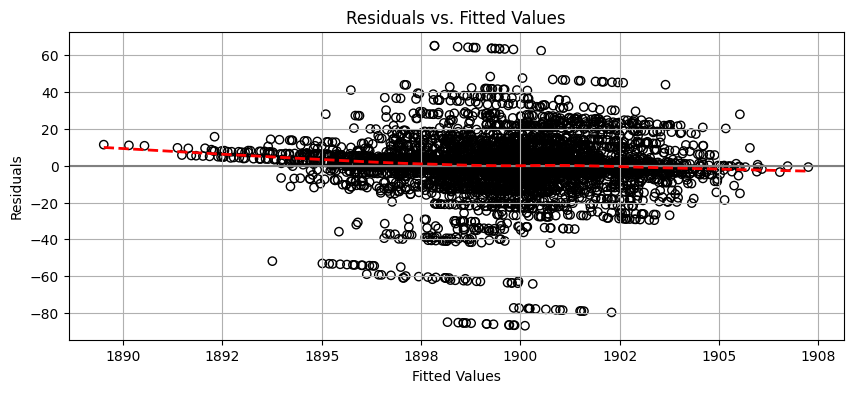

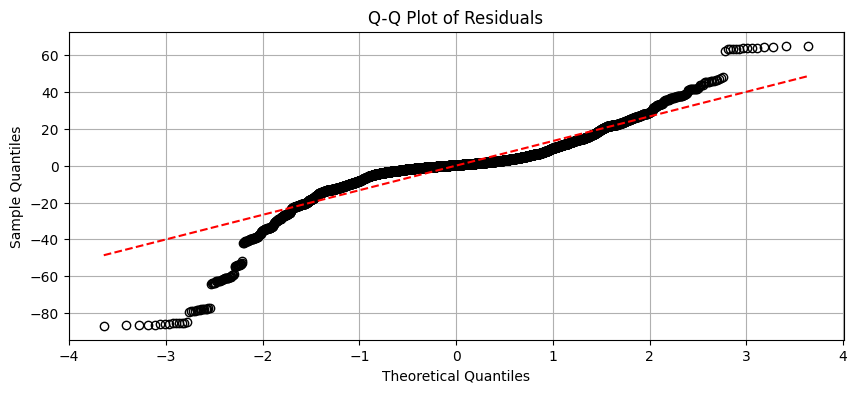

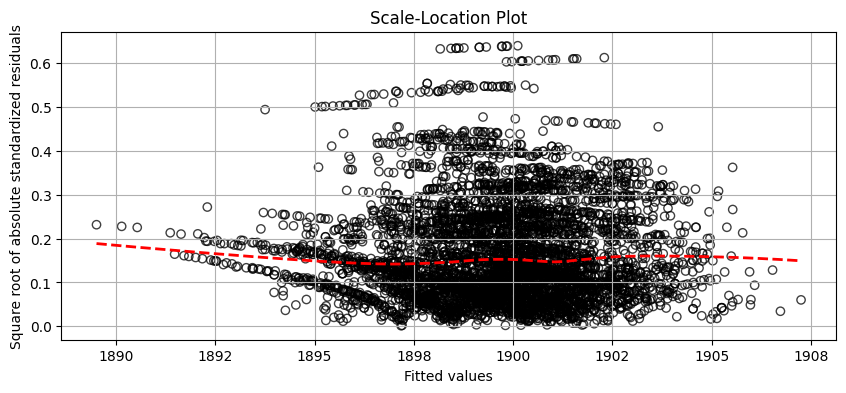

In [32]:
graphs(lm_model)

In [36]:
#Examine outlier groups

#Get the indices where residuals are between -65 and -50 , <-80 and >60

#Read CH4 imputed file again
outlier_CH4 = pd.read_excel(Merged_CH4_path_imputed,index_col=0)

residuals = lm_model.resid
indices = np.where((residuals >60))[0]
#OR: indices = np.where((residuals <-80))[0]
#OR: indices = np.where((residuals >= -65) & (residuals <= -50))[0]

outlier_dates=pd.DataFrame(columns=['datetime'])

for i in indices:
    print(all_stations.iloc[i]['datetime'], ',', all_stations.iloc[i]['Station'])
    current_date=all_stations.iloc[i]['datetime']

    if current_date  not in outlier_dates['datetime'].values: 
        new_row = pd.DataFrame({'datetime': [current_date]})
        outlier_dates = pd.concat([outlier_dates, new_row], ignore_index=True)

outlier_dates['ID']=np.nan
outlier_dates['CH4_imputed']=np.nan


for j in outlier_dates.itertuples():

    for k in outlier_CH4.itertuples():
       if j.datetime==k.datetime: 
          
          index=int(j.Index)

          outlier_dates.iloc[index,1]=k.ID
          outlier_dates.iloc[index,2]=k._4 #access 'CH4 column' which is the 4th one

        
#Unique dates
print()
print(outlier_dates)

2023-08-01 00:00:00 , Agios
2023-08-01 00:00:00 , Aliveri
2023-08-01 00:00:00 , Aspropyrgos
2023-08-01 00:00:00 , Atherinolakkos
2023-08-01 00:00:00 , Chania
2023-08-01 00:00:00 , Corinth
2023-08-01 00:00:00 , Komotini
2023-08-01 00:00:00 , Lavrio
2023-08-01 00:00:00 , Linoperamata
2023-08-01 00:00:00 , Megalopoli
2023-08-01 00:00:00 , Ptolemaida
2023-08-01 00:00:00 , South
2023-08-01 00:00:00 , Thessaloniki
2023-08-01 00:00:00 , Thiva

    datetime     ID  CH4_imputed
0 2023-08-01  South  1962.892082


In [37]:
# Generalized Linear Model: ln(CH4) =bo+b1*CO+... where CH4 follows Gaussian distribution
GLM = sm.GLM(y, X, family=sm.families.Gaussian(sm.families.links.Log()))

GLM_results = GLM.fit()

print(GLM_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    CH4   No. Observations:                 5110
Model:                            GLM   Df Residuals:                     5102
Model Family:                Gaussian   Df Model:                            7
Link Function:                    Log   Scale:                          212.52
Method:                          IRLS   Log-Likelihood:                -20939.
Date:                Sat, 09 Nov 2024   Deviance:                   1.0843e+06
Time:                        18:12:05   Pearson chi2:                 1.08e+06
No. Iterations:                     4   Pseudo R-squ. (CS):            0.02265
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              7.5627      0.002   4990.

In [38]:
#Model with Interaction Terms for O3 and aerosol_index
interaction = smf.ols(formula="CH4 ~ CO + NO2 + SO2 + HCHO  + cloud_fraction + O3 + aerosol_index + O3: aerosol_index", data=all_stations_model).fit()
interaction.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    CH4   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     15.39
Date:                Sat, 09 Nov 2024   Prob (F-statistic):           1.44e-22
Time:                        18:12:08   Log-Likelihood:                -20936.
No. Observations:                5110   AIC:                         4.189e+04
Df Residuals:                    5101   BIC:                         4.195e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         1921.6119      3.160    608.087      0.000    1915.417    1927.807
CO                 -83.2972     61.474     -1.355      0.175    -203.813      37.218
NO2              -4572.9170   6791.497     -0.673      0.501   -1.79e+04    8741.332
SO2                977.5466    430.230      2.272      0.023     134.111    1820.982
HCHO             -2675.7050   1804.091     -1.483      0.138   -6212.497     861.087
cloud_fraction       1.1786      0.615      1.916      0.055      -0.027       2.385
O3                -136.1194     18.445     -7.380      0.000    -172.279     -99.960
aerosol_index       -9.3646      3.419     -2.739      0.006     -16.068      -2.661
O3:aerosol_index    58.2286     23.795      2.447      0.014      11.580     104.877
==============================================================================
Omnibus:                     1563.485   Durbin-Watson:                   1.693
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15587.364
Skew:                          -1.169   Prob(JB):                         0.00
Kurtosis:                      11.231   Cond. No.                     3.77e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.77e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

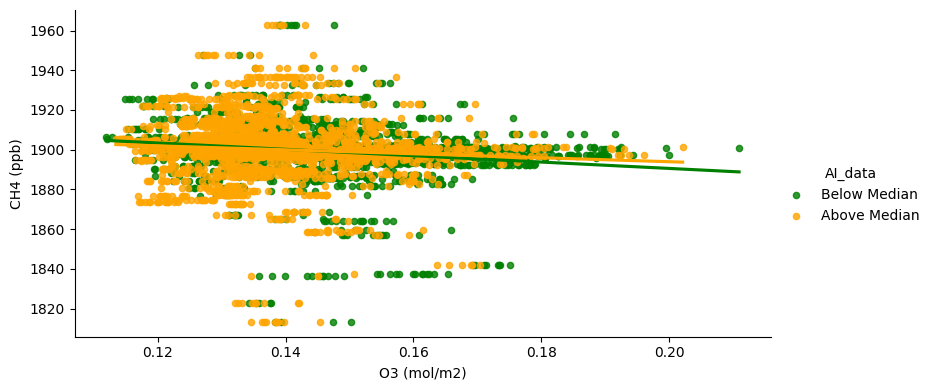

In [39]:
#Create interaction plot for O3 and AI

#Select O3,AI,CH4 columns only
df_inter = all_stations_model[['O3', 'aerosol_index', 'CH4']].copy()

# Create a binary variable based on the median of AI
df_inter['AI_data'] = np.where(df_inter['aerosol_index'] > df_inter['aerosol_index'].median(), 'Above Median', 'Below Median')

palette = {'Below Median': 'green', 'Above Median': 'orange'} 

plot=sns.lmplot(x='O3', y='CH4', hue='AI_data', data=df_inter, ci=None, height=4, aspect=2,scatter_kws={'marker': '-', 'alpha': 0.8,'s': 20}, palette=palette)

plt.xlabel('O3 (mol/m2)')
plt.ylabel('CH4 (ppb)')
plt.show()


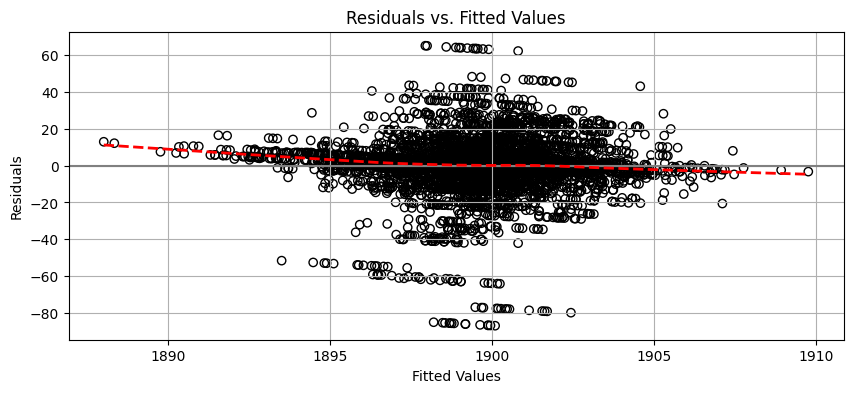

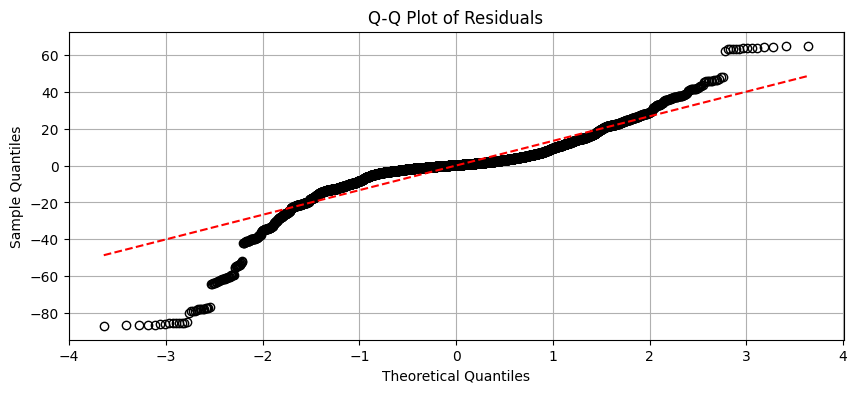

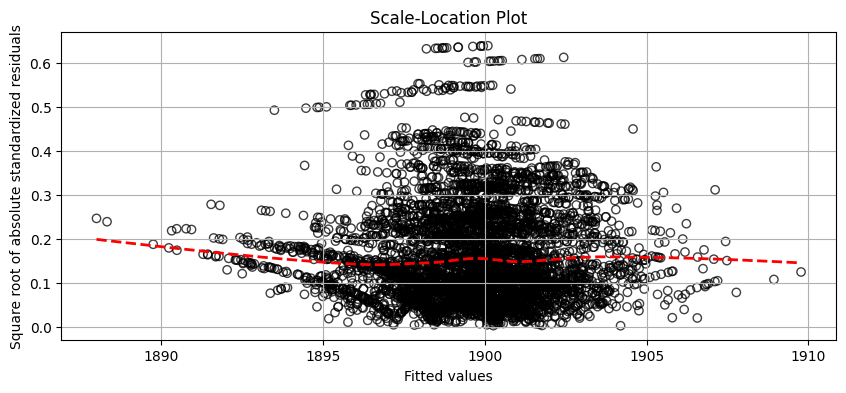

In [40]:
#Model graphs for model with interaction terms
graphs(interaction)

In [41]:
#Model with polynomial terms for O3 (or AI)

#Create a new dataframe 
new_stations = pd.DataFrame(all_stations_model)

#Create polynomial features for O3 and aerosol_index
poly_transformer = PolynomialFeatures(degree=3, include_bias=False)

#Polynomial transformation for O3
O3_poly = poly_transformer.fit_transform(new_stations[['O3']])
new_stations['O3_poly1'] = O3_poly[:, 0]  #O3
new_stations['O3_poly2'] = O3_poly[:, 1]  #O3^2
new_stations['O3_poly3'] = O3_poly[:, 2]  #O3^2

#Polynomial transformation for aerosol_index
AI_poly = poly_transformer.fit_transform(new_stations[['aerosol_index']])
new_stations['AI_poly1'] = AI_poly[:, 0]  #aerosol_index
new_stations['AI_poly2'] = AI_poly[:, 1]  #aerosol_index^2

#Define the final formula
formula = 'CH4 ~ CO + NO2 + SO2 + HCHO + O3_poly1 + O3_poly2 + AI_poly1 +cloud_fraction'

#Fit the model using ordinary least squares 
poly = smf.ols(formula=formula, data=new_stations).fit()

summary = poly.summary2()
print(summary)



                     Results: Ordinary least squares
Model:                OLS                Adj. R-squared:       0.022     
Dependent Variable:   CH4                AIC:                  41890.4117
Date:                 2024-11-09 18:15   BIC:                  41949.2622
No. Observations:     5110               Log-Likelihood:       -20936.   
Df Model:             8                  F-statistic:          15.36     
Df Residuals:         5101               Prob (F-statistic):   1.61e-22  
R-squared:            0.024              Scale:                212.32    
-------------------------------------------------------------------------
                 Coef.     Std.Err.    t     P>|t|     [0.025     0.975] 
-------------------------------------------------------------------------
Intercept       1961.8958   15.7245 124.7667 0.0000   1931.0690 1992.7226
CO               -67.6536   61.6590  -1.0972 0.2726   -188.5317   53.2245
NO2            -5505.5762 6784.6494  -0.8115 0.4171 -18806.

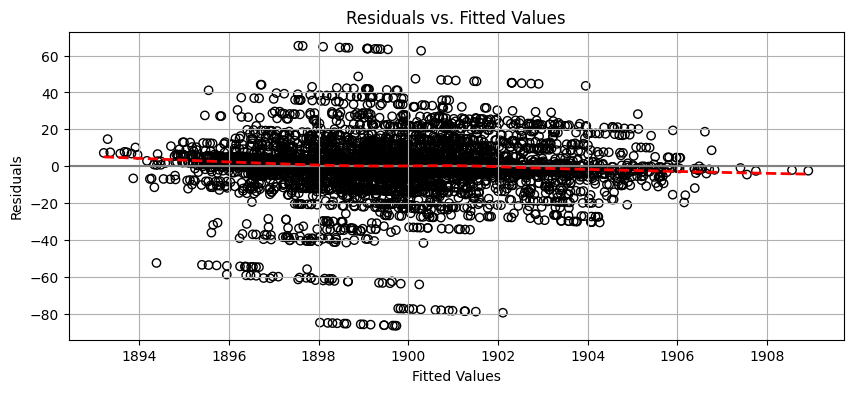

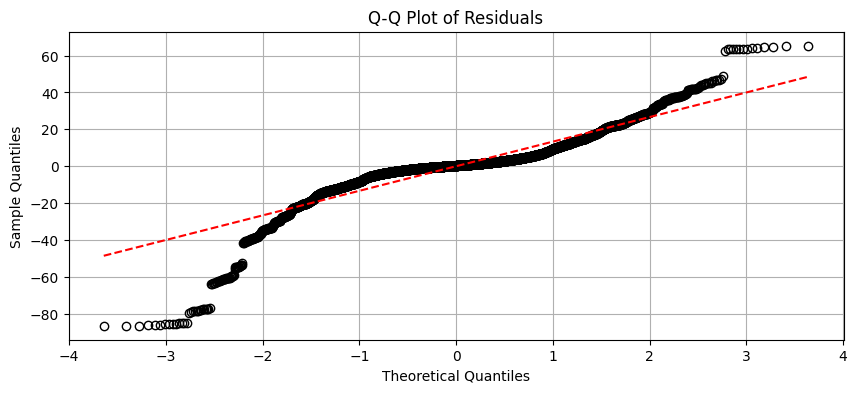

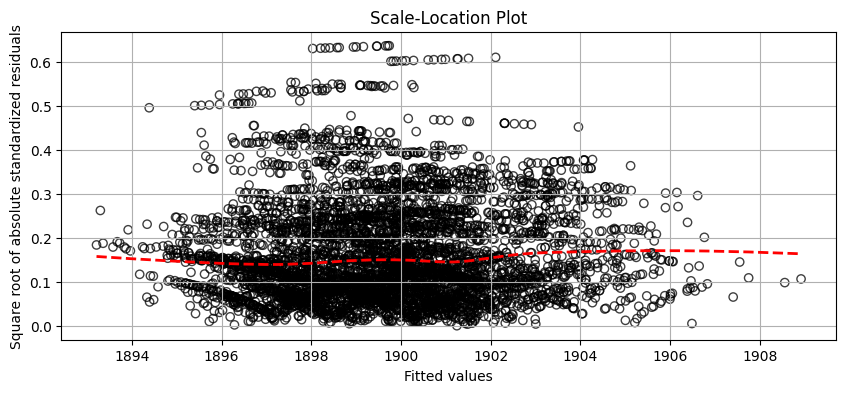

In [103]:
#Model graphs for polynomial model
graphs(poly)

In [42]:
#Non linear models
#Random forest

y = all_stations_model['CH4']
X = all_stations_model[['CO', 'NO2', 'SO2', 'HCHO', 'O3', 'aerosol_index', 'cloud_fraction']]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)   

#Apply random forest regressor
clf=RandomForestRegressor(n_estimators=100,oob_score=True, bootstrap=True, random_state=42)
clf.fit(X_train,y_train)

#Predicting the test set results
y_pred = clf.predict(X_test)

#Extract feature importances
importance = clf.feature_importances_

#Combine the feature names with their importance scores for easier interpretation
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importance
})

# Print the feature importances
print(feature_importance_df)

          Feature  Importance
0              CO    0.159674
1             NO2    0.121821
2             SO2    0.123010
3            HCHO    0.120566
4              O3    0.190280
5   aerosol_index    0.165577
6  cloud_fraction    0.119072


In [43]:
#Random forest statistcial values

#Print R2 value
r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2}")

#Print OOB score
oob_error = 1 - clf.oob_score_
print("OOB Score:",oob_error )


R-squared: 0.03342331309523616
OOB Score: 1.0067685070693908


Text(0.5, 1.0, 'Feature Importance')

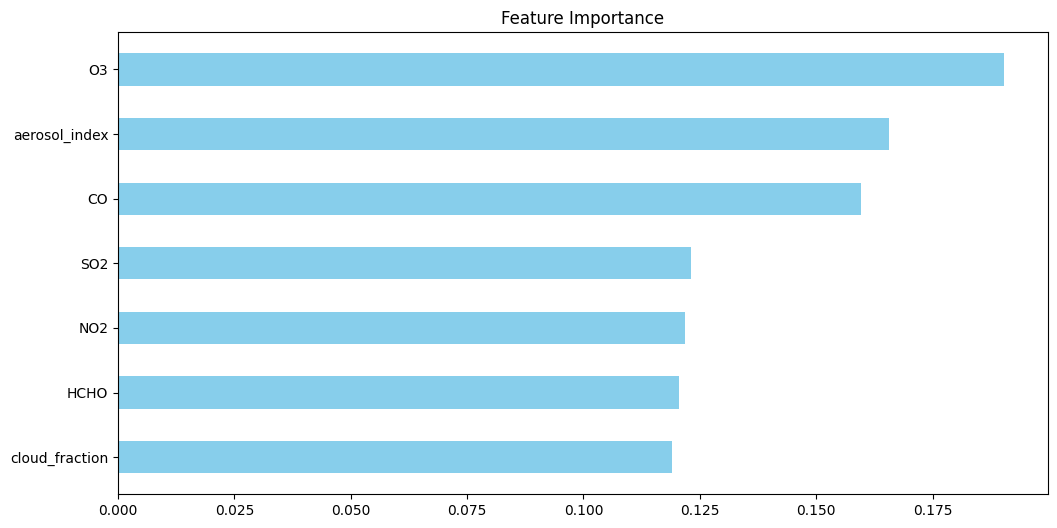

In [44]:
#Source: https://www.rasgoml.com/feature-engineering-tutorials/how-to-generate-feature-importance-plots-from-scikit-learn

#Feature Importance: horizontal bar chart
sorted_idx = np.argsort(importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), importance[sorted_idx], align='center',height=0.5,color='skyblue')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')

In [110]:
#VIF test for Multicollinearity, source: https://www.geeksforgeeks.org/detecting-multicollinearity-with-vif-python/

#New dataframe with all variables minus CH4
vif_data=all_stations_model.drop('CH4',axis=1)

#Add constant for the VIF function to work properly
vif_data = add_constant(vif_data)

#VIF dataframe
vif = pd.DataFrame()
vif["feature"] = vif_data.columns

#Calculating VIF for each feature
vif["VIF"] = [variance_inflation_factor(vif_data.values, i)
                          for i in range(len(vif_data.columns))]


print(vif)

          feature         VIF
0           const  199.153153
1              CO    1.075936
2             NO2    1.086098
3             SO2    1.007175
4            HCHO    1.055099
5              O3    1.171497
6   aerosol_index    1.139310
7  cloud_fraction    1.178779


In [45]:
#AIC for best lag

#Create VAR model for data
var_data=pd.DataFrame()
var_data=all_stations_model[['CH4', 'aerosol_index']]
var=VAR(var_data)

var_all=VAR(all_stations_model)

In [49]:
#Run AIC criterion for maximum 30 lags

max_lags=30
aic_values = []

for lag in range(1,max_lags+1):
    model=var_all.fit(lag)
    aic_values.append(model.aic)

lags = list(range(1, max_lags + 1))

results_AIC=pd.DataFrame({
    'lag': lags,
    'AIC': aic_values
})

print(results_AIC,'\n')
min=(results_AIC['AIC'].idxmin())+1
print('Best lag: ',min)


    lag        AIC
0     1 -73.899917
1     2 -74.036820
2     3 -74.096542
3     4 -74.223677
4     5 -74.373094
5     6 -74.423473
6     7 -74.461154
7     8 -74.493220
8     9 -74.503119
9    10 -74.538971
10   11 -74.595843
11   12 -74.614782
12   13 -74.622367
13   14 -74.637842
14   15 -74.651625
15   16 -74.682698
16   17 -74.681711
17   18 -74.692512
18   19 -74.719261
19   20 -74.740305
20   21 -74.758833
21   22 -74.768071
22   23 -74.782628
23   24 -74.791675
24   25 -74.802638
25   26 -74.800928
26   27 -74.813832
27   28 -74.820253
28   29 -74.828699
29   30 -74.847206 

Best lag:  30


In [113]:
#Test Granger causality between CH4 and the rest of the variables

#All independent variables
cols=all_stations_model.columns.drop('CH4')

#Store output in the following dataframe
output=pd.DataFrame(columns=['Variable','p_value','Test_result'])


for var in cols:
    Granger=grangercausalitytests(all_stations_model[['CH4', var]], [30],verbose=False)
    p_val=Granger[30][0]['ssr_ftest'][1]
    if p_val<=0.05: Test_result=True
    else: Test_result=False
    new_row={'Variable':var,'p_value':p_val,'Test_result':Test_result}
    new_row_df = pd.DataFrame([new_row])
    output=pd.concat([output,new_row_df],ignore_index=True)

output

c:\ANACONDA\envs\sentinel5p\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\ANACONDA\envs\sentinel5p\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\ANACONDA\envs\sentinel5p\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\ANACONDA\envs\sentinel5p\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\ANACONDA\envs\sentinel5p\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\ANACONDA\envs\sentinel5p\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated si

,Variable,p_value,Test_result
0,CO,5.596024e-17,True
1,NO2,2.909151e-05,True
2,SO2,9.786564e-02,False
3,HCHO,5.119661e-02,False
4,O3,2.215738e-53,True
5,aerosol_index,1.358954e-22,True
6,cloud_fraction,2.404122e-12,True
